# 1. Instalamos las  dependencias

In [65]:
# Comprobamos si está conectado a una GPU e instalamos las dependencias correspondientes.
!nvidia-smi -L
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  %pip install llama-cpp-python
else:
  print(gpu_info)
  !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 --force-reinstall --upgrade --no-cache-dir --verbose

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-7eff9722-3874-1a62-3bc7-79909ed66bf4)
Wed Nov  1 13:11:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0  On |                  N/A |
| 33%   37C    P8              18W / 172W |   3336MiB /  6144MiB |      2%      Default |
|                                         |                      |            

"CMAKE_ARGS" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [1]:
%pip install datasets huggingface_hub seaborn
#Si hay disponible una tarjeta gráfica:
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 --force-reinstall --upgrade --no-cache-dir --verbose
#En caso contrario:
#%pip install llama-cpp-python


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.6 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.6 kB 487.6 kB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Install ipykernel

# 2. Descargamos el dataset y el modelo

In [50]:
from llama_cpp import Llama
from datasets import load_dataset
from huggingface_hub import hf_hub_download
# Descargamos un dataset de huggingface.com usando la librería datasets
dataset = load_dataset("mesmalif/amazon-shoe-reviews")
# Seleccionamos un conjunto de test de ese dataset.
test_dataset = dataset["test"].to_iterable_dataset()

# Este el nombre del modelo que vamos a utitilizar también de huggingface
# usando la librería huggingface_hub
model_name_or_path = "TheBloke/CodeLlama-7B-Instruct-GGUF"
model_basename = "codellama-7b-instruct.Q4_K_M.gguf"
# model_name_or_path = "TheBloke/Llama-2-7b-Chat-GGUF"
# model_basename = "llama-2-7b-chat.Q4_K_M.gguf"
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename,)

llm = Llama(model_path=model_path,
n_gpu_layers=30, #Sólo para GPU
n_gqa=8,
verbose=True)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 0 | VSX = 0 | 


# 3. Cargamos el dataset en un Dataframe y lo preparamos para procesar el análisis

In [ ]:
import pandas as pd
df = pd.json_normalize(test_dataset)
df = df.sample(frac=0.001)
df.reset_index(drop=True, inplace=True)
df['review'] = df['review_headline'] + ". " + df['text']
df['star_rating'] = df['labels'] + 1
df['prediction'] = None
df.head()

In [ ]:
import json
def parse_response(response):
        if type(response) == dict:
            if response.keys().__contains__("choices"):
                return parse_response(response["choices"][0])
            elif response.keys().__contains__("text"):
                
                return parse_response(response["text"])
            else:
                return response
            
        if type(response) == str:
            return json.loads(clean_response(response))
          

def clean_response(response):
    
    start = response.find("{")
    end = response.rfind("}") + 1
    temp = response[start:end]
    temp = temp.replace("'", '"')
    temp = temp.replace(": False,", ': "False",')
    temp = temp.replace(": True,", ': "True",')
    return temp


## 4. Procesamos el dataset y actualizamos los valores en el Dataframe

In [58]:
import time
import json
start = time.time()
count = 0

for i in range(df.shape[0]):
    reviewText = df.at[i, 'review']
    categoria = df.at[i,'product_category']
    prompt =f'[INST] Return a json with the following information extracted from the {categoria} review below you can find the review between triple backticks: \
    {{ \
        "Sentiment": "(Positive or Negative)",\
        "Stars": "Number of stars depending on the sentiment of the Review",\
        "Anger": "Is the user angry (True or False)", \
        "Product": "The name of the product reviewed", \
        "Brand": "The brand name of the product reviewed", \
        "Product type": ""The type of the product reviewed", \
        "Language": "The language of the review in ISO 639-1 format" \
    }} \
Review: ```' + \
reviewText + \
'``` \
If the information is not present, use ""unknown"" as the value. \
Remember to return only the json. \
[/INST]'
    output = llm(prompt, echo=False)
    try:
        response = parse_response(output)
        df.at[i,"prediction"] = response["Stars"]
    except:
        print("Prompt:", prompt)
        print("Output: ", output)
        print("Response: ", response)
end = time.time()
print((end - start)/60)

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


4.278134989738464


## 5. Mostramos la matriz de confusión

In [59]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
from sklearn.metrics import confusion_matrix
import seaborn as sn

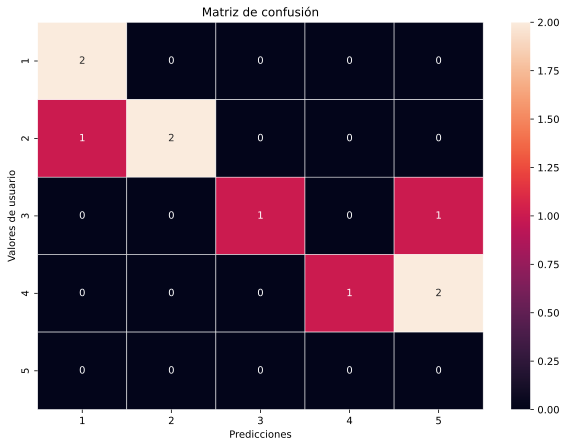

In [60]:
df_drop = df.replace('', np.nan)
df_drop = df_drop.dropna(subset=['prediction','star_rating'])
df_drop = df_drop.astype({'prediction': 'int', 'star_rating': 'int'}, errors='ignore')

array = confusion_matrix(y_true=df_drop['star_rating'], y_pred=df_drop['prediction'], labels = [1,2,3,4,5])

df_cm = pd.DataFrame(array, index = [i for i in [1,2,3,4,5]],
                  columns = [i for i in [1,2,3,4,5]])

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
ax.set_title(f'Matriz de confusión')
ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores de usuario')
plt.show()